# Implementing a Key-Value Database

In this project, we'll implement a key-value database that will be flexible and easy for other developers to use in their own projects. We'll build off of a B-Tree class and turn it into a fully functional key-value store.

A key-value database operates similarly to a Python dictionary, but it allows the users to perform a range of queries. We'll be building a database similar to other open-source implementations of a key-value store like Redis, CouchDB, Mongo, and Cassandra. 

## Implementing a B-Tree

Before we create our key-value database, we'll need to add in a B-tree class implementation.

### Node Class

To implement a B-tree from scratch, we'll need to create a `Node` class so that we can use two separate lists to represent the keys and the children.

We'll also implement an `is_leaf` method so we know if the node is a leaf – has no children – or not. We'll also add a `__repr__()` method so that we can track the number of keys contained within a B-tree node.

In [1]:
import bisect

class Node:

    def __init__(self, keys=None, values=None, children=None, parent=None):
        self.keys = keys or []
        self.values = values or []
        self.parent = parent
        self.set_children(children)

    def set_children(self, children):
        self.children = children or []
        for child in self.children:
            child.parent = self

    def is_leaf(self):
        return len(self.children) == 0

    def contains_key(self, key):
        return key in self.keys
    
    def get_value(self, key):
        for i, k in enumerate(self.keys):
            if k == key:
                return self.values[i]
        return None

    def get_insert_index(self, key):
        return bisect.bisect(self.keys, key)

    def insert_entry(self, key, value):
        insert_index = self.get_insert_index(key)
        self.keys.insert(insert_index, key)
        self.values.insert(insert_index, value)
        return insert_index

    def split(self):
        if self.parent is None:
            return self.split_no_parent()
        return self.split_with_parent()

    def split_no_parent(self):
        split_index = len(self) // 2
        key_to_move_up = self.keys[split_index]
        value_to_move_up = self.values[split_index]
        # Create right node
        right_node = Node(self.keys[split_index+1:], self.values[split_index+1:], self.children[split_index+1:])
        # Update left node (self)
        self.keys = self.keys[:split_index]
        self.values = self.values[:split_index]
        self.children = self.children[:split_index+1]
        # Create parent
        parent = Node([key_to_move_up], [value_to_move_up], [self, right_node])
        return parent

    def insert_child(self, insert_index, child): 
        self.children.insert(insert_index, child)
        child.parent = self

    def split_with_parent(self): 
        split_index = len(self) // 2
        key_to_move_up = self.keys[split_index]
        value_to_move_up = self.values[split_index]
        # Create right node
        right_node = Node(self.keys[split_index+1:], self.values[split_index+1:], self.children[split_index+1:])
        # Update left node (self)
        self.keys = self.keys[:split_index]
        self.values = self.values[:split_index]
        self.children = self.children[:split_index+1]
        # Add new child to parent
        key_insert_index = self.parent.insert_entry(key_to_move_up, value_to_move_up)
        self.parent.insert_child(key_insert_index + 1, right_node)
        return self.parent

    def __len__(self):
        return len(self.values)

### B-Tree Class

The following code represents the B-tree class.

In [2]:
class BTree:

    def __init__(self, split_threshold):
        self.root = Node()
        self.split_threshold = split_threshold 
        self.height = 0
        self.size = 0

    def __len__(self):
        return self.size
    
    def _find_node(self, current_node, key):
        if current_node.contains_key(key):
            return current_node
        if current_node.is_leaf():
            return None
        child_index = current_node.get_insert_index(key) 
        return self._find_node(current_node.children[child_index], key)
    
    def contains(self, key):
        node = self._find_node(self.root, key)
        if node is None:
            return False
        return True
    
    def _add(self, current_node, key, value):
        if current_node.is_leaf(): 
            current_node.insert_entry(key, value) 
        else:
            child_index = current_node.get_insert_index(key) 
            self._add(current_node.children[child_index], key, value)
        if len(current_node) > self.split_threshold: 
            parent = current_node.split()  
            if current_node == self.root: 
                self.root = parent
                self.height += 1
                
    def add(self, key, value):
        self._add(self.root, key, value)
        self.size += 1
        
    def get_value(self, key):
        node = self._find_node(self.root, key)
        if node is None:
            return None
        return node.get_value(key)

## Override the Initializer

Next, we'll declare a new class called `KVStore()` which will be a new extension of the `BTree` class above.

In [3]:
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)
        
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            for i, node_key in enumerate(node.keys):
                if node_key == key:
                    node.values[i] = value

### Testing KVStore( )

We're going to test the implementation we just created to make sure `KVStore()` works properly. To do this, we're going to add assertions that will ensure the state of the object is what it's supposed to be. 

In [4]:
kvs = KVStore()

# Test the split threshold
assert kvs.split_threshold == 2, "Split Threshold is 2"

# Test the .add() and .get_value() methods
for i in range(10):
    kvs.add(i, i)
    
for i in range(10):
    assert kvs.get_value(i) == i, "i is i"

# Testing two entries with the same key and different values
for i in range(10):
    kvs.add(i, i + 1)
    
for i in range(10):
    assert kvs.get_value(i) == i + 1, "i is i + 1"

## Implement the Get & Set

We'll copy our `KVStore()` class from above and add `__setitem__` and `__getitem__`.

In [5]:
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)
        
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            for i, node_key in enumerate(node.keys):
                if node_key == key:
                    node.values[i] = value
    
    # Add the get and set methods
    def __setitem__(self, key, value):
        self.add(key, value)
        
    def __getitem__(self, key):
        return self.get_value(key)

### Testing the Get & Set Methods

We'll run the same tests we ran earlier, but with a bracket syntax.

In [6]:
kvs = KVStore()

# Test the split threshold
assert kvs.split_threshold == 2, "Split Threshold is 2"

# Test the .add() and .get_value() methods
for i in range(10):
    kvs[i] = i
    
for i in range(10):
    assert kvs[i] == i, "i is i"

# Testing two entries with the same key and different values
for i in range(10):
    kvs[i] = i + 1
    
for i in range(10):
    assert kvs[i] == i + 1, "i is i + 1"

## Implementing a New `contains` Method

Next, we'll implement a contains method to check if a given key is contained within the data structure. The `BTree` class already had a `contains()` method, so we'll just enhance it in our new class using `__contains__()`.

In [7]:
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)
        
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            for i, node_key in enumerate(node.keys):
                if node_key == key:
                    node.values[i] = value
                    
    def __setitem__(self, key, value):
        self.add(key, value)
        
    def __getitem__(self, key):
        return self.get_value(key)
    
    # Add the contains method
    def __contains__(self, key):
        return self.contains(key)

## Testing the `in` Operator

Here we'll test whether or not we can use the `in` operator on an instance of `KVStore()`.

In [8]:
kvs = KVStore()

for char in 'abcdefghijklmnopqrstuvwxyz':
    kvs[char] = char
    
for char in 'abcdefghijklmnopqrstuvwxyz':
    assert char in kvs, 'Character in key-value store'

## Implementing Range Queries

A previous implementation of `range_query` in `KVStore()` only supports numeric keys. We'll need to remake this implementation so that it is more general where we can use other data types like strings.

In [9]:
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)
        
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            for i, node_key in enumerate(node.keys):
                if node_key == key:
                    node.values[i] = value
                    
    def __setitem__(self, key, value):
        self.add(key, value)
        
    def __getitem__(self, key):
        return self.get_value(key)
    
    def __contains__(self, key):
        return self.contains(key)

    # Add the range queries methods
    def _range_query(self, range_begin, range_end, current_node, min_key, max_key):
        if range_begin > max_key or range_end < min_key:
            return []
        results = []
    
        for i, key in enumerate(current_node.keys):
            if range_begin <= key and key <= range_end:
                results.append(current_node.values[i])
        if not current_node.is_leaf():
            for i, child in enumerate(current_node.children):
                new_min_key = current_node.keys[i - 1] if i > 0 else min_key
                new_max_key = current_node.keys[i] if i < len(current_node) else max_key
                results += self._range_query(range_begin, range_end, child, new_min_key, new_max_key)
        return results
    
    def range_query(self, range_begin, range_end):
        return self._range_query(range_begin, range_end, self.root, float('-inf'), float('inf'))

## Testing `KVStore()`

In [10]:
class DictKVStore(dict):

    def range_query(self, range_start, range_end):
        result = []
        for key in self.keys():
            if range_start <= key and key <= range_end:
                result.append(self[key])
        return result

In [11]:
dict_kv = DictKVStore()
our_kv = KVStore()
for i in range(10):
    dict_kv[i] = i
    our_kv[i] = i

for range_start, range_end in [(1, 3), (4, 6), (1, 10), (5, 5)]:
    dict_res = sorted(dict_kv.range_query(range_start, range_end))
    our_res = sorted(our_kv.range_query(range_start, range_end))
    assert dict_res == our_res, "Both data structures return the same range query result."

## Performance Testing

Lastly, we will perform some speed tests. We'll do this by creating some large .csv files, one with keys and values, the other with number ranges. We'll load in the entries in our `entries.csv`, and then loop over the queries in our `queries.csv`. For each query, we'll measure the execution times and runtime, and compute the ratio between them. Then, we can plot those values to better visualize the efficiency of `KVStore()`.

### Creating CSV Files

We need to first create data files that we will use to test our key-value store on.

First, we'll create `entries.csv`.

In [12]:
import pandas as pd
import numpy as np
import random

# Generate a list of keys from 0 to 49999
rand_keys = random.sample(range(0, 50000), 50000)

# Convert to a pandas dataframe
entries = pd.DataFrame(rand_keys)

# Generate a list of random values
rand_val = np.random.randint(50000,100000,size=(50000, 1))

# Add to our dataframe
entries['value'] = rand_val

# Add column names
entries.columns = ['key', 'value']

# Export as .csv
entries.to_csv(r'entries.csv', header=True, index=False)

Next, we'll create `queries.csv`.

In [13]:
# Generate a dataframe of random range starts from 0 to 49999
queries = pd.DataFrame(np.random.randint(0,1000,size=(50000, 1)))

# Add an end of range column that add a random number to the range start value
queries['range_end'] = queries.apply(lambda range_start: range_start + np.random.randint(0, 1000), axis=1)

# Add column names
queries.columns = ['range_start', 'range_end']

# Export as .csv
queries.to_csv(r'queries.csv', header=True, index=False)

### Testing `KVStore()` Performance

Now that we've generated our test files, we can test our `KVStore()` efficiency vs. `DictKVStore()`.

In [14]:
import time
import csv

dict_kv = DictKVStore()
our_kv = KVStore()

# Loading entries.csv
with open('entries.csv', 'r') as f:
    rows = list(csv.reader(f))[1:]
    for row in rows:
        key = int(row[0])
        value = int(row[1])
        dict_kv[key] = value
        our_kv[key] = value
        
# Calculate query times
time_ratios = []

with open('queries.csv', 'r') as f:
    rows = list(csv.reader(f))[1:]
    for row in rows:
        range_start = int(row[0])
        range_end = int(row[1])
        
        start = time.time()
        dict_kv.range_query(range_start, range_end)
        time_dict = time.time() - start
        
        start = time.time()
        our_kv.range_query(range_start, range_end)
        time_kv = time.time() - start
        
        time_ratios.append(time_dict / time_kv)

### Plotting the Results

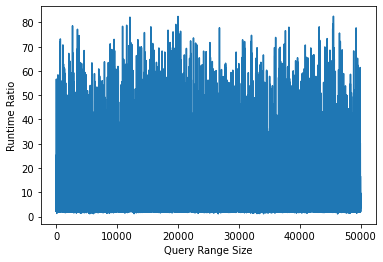

In [15]:
import matplotlib.pyplot as plt

plt.plot(time_ratios)
plt.xlabel('Query Range Size')
plt.ylabel('Runtime Ratio')
plt.show()

We can see that with 50,000 entries, we get a massive performance boost.

## Conclusion & Next Steps

We've successfully implemented a key-value database! All by building off of a B-Tree class, and now we can continue to use this database for other projects.

Some next steps we could take in order to continue improving our key-value store could be to: 

* Create a save method and load method to be able to save or load the key-value store into a file.
* Make the key-value store iterable.
* Implement a new `BTree` from scratch that works even better than the one we used.

The idea for this project comes from the [dataquest.io](https://www.dataquest.io) **Recursion and Trees**  course.